In [1]:

import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rioxarray as rxr  # habilita .rio en xarray
from shapely.geometry import mapping
import rasterio
from rasterio.features import shapes as rio_shapes
from rasterio import features as rio_features


In [2]:
# === RUTAS / PARÁMETROS ===
NC_PATH   = "/home/aninotna/magister/tesis/justh2_pipeline/data/mapbioma/nc/uso_suelo_stack.nc"                # tu NetCDF
VAR_NAME  = "uso_suelo"                         # nombre de variable
YEAR      = 2020                                # el año que quieres inspeccionar
ROI_PATH  = "/home/aninotna/magister/tesis/justh2_pipeline/data/coords/valle_aconcagua_coords.geojson"    # tu ROI
OUT_TIF   = "uso_suelo_2020_roi.tif"            # salida GeoTIFF recortada
OUT_CSV   = "uso_suelo_2020_roi_counts.csv"     # conteo de clases


In [3]:
try:
    import dask  # noqa
    ds = xr.open_dataset(NC_PATH, chunks={"lat": 1000, "lon": 1000})
    print("[INFO] Abierto con Dask + chunks.")
except Exception as e:
    print("[INFO] Dask no disponible o no deseado; abriendo sin chunks:", e)
    ds = xr.open_dataset(NC_PATH)

[INFO] Abierto con Dask + chunks.


In [4]:
# ---- Resumen general
print("\n=== Dataset summary ===")
print(ds)
print("\nAtributos DS:", ds.attrs)



=== Dataset summary ===
<xarray.Dataset> Size: 1GB
Dimensions:    (year: 23, lat: 3733, lon: 7008)
Coordinates:
  * year       (year) int64 184B 2000 2001 2002 2003 ... 2019 2020 2021 2022
  * lat        (lat) float64 30kB -32.26 -32.26 -32.26 ... -33.27 -33.27 -33.27
  * lon        (lon) float64 56kB -71.89 -71.89 -71.89 ... -70.0 -70.0 -70.0
Data variables:
    uso_suelo  (year, lat, lon) int16 1GB dask.array<chunksize=(23, 1000, 1000), meta=np.ndarray>

Atributos DS: {}


In [6]:
VAR_NAME  = "uso_suelo"
# ---- Variables y coordenadas
if VAR_NAME not in ds.data_vars:
    raise ValueError(f"La variable '{VAR_NAME}' no existe. Variables disponibles: {list(ds.data_vars)}")

da = ds[VAR_NAME]
print("\n=== Variable objetivo ===")
print(f"Nombre: {VAR_NAME}")
print("Dims:", da.dims, " | dtype:", da.dtype)
print("Attrs var:", da.attrs)
print("Encoding var:", da.encoding)


=== Variable objetivo ===
Nombre: uso_suelo
Dims: ('year', 'lat', 'lon')  | dtype: int16
Attrs var: {}
Encoding var: {'dtype': dtype('int16'), 'zlib': False, 'szip': False, 'zstd': False, 'bzip2': False, 'blosc': False, 'shuffle': False, 'complevel': 0, 'fletcher32': False, 'contiguous': True, 'chunksizes': None, 'source': '/home/aninotna/magister/tesis/justh2_pipeline/data/mapbioma/nc/uso_suelo_stack.nc', 'original_shape': (23, 3733, 7008)}


In [8]:
# ---- Años y rangos espaciales
years = da.coords["year"].values if "year" in da.dims else None
if years is not None:
    print(f"\nAños disponibles: {int(years.min())} .. {int(years.max())}  (n={len(years)})")

lat = ds["lat"].values
lon = ds["lon"].values
print(f"Latitud: min={float(lat.min()):.5f}, max={float(lat.max()):.5f}, n={lat.size}")
print(f"Longitud: min={float(lon.min()):.5f}, max={float(lon.max()):.5f}, n={lon.size}")



Años disponibles: 2000 .. 2022  (n=23)
Latitud: min=-33.26776, max=-32.26201, n=3733
Longitud: min=-71.89226, max=-70.00391, n=7008


In [9]:
SELECT_YEAR = 2022

In [10]:
# ---- Códigos únicos y frecuencias (para un año)
if years is not None:
    if SELECT_YEAR not in years:
        print(f"[WARN] Año {SELECT_YEAR} no está en el dataset. Usaré {int(years[0])}.")
        SELECT_YEAR = int(years[0])
    da_year = da.sel(year=SELECT_YEAR)
else:
    da_year = da


In [12]:
arr = da_year.values  # carga a memoria solo ese año (típicamente ~50–60 MB)
codes, counts = np.unique(arr, return_counts=True)
df_counts = pd.DataFrame({"code": codes.astype(np.int64), "count": counts})
df_counts["fraction"] = df_counts["count"] / df_counts["count"].sum()
df_counts = df_counts.sort_values("count", ascending=False).reset_index(drop=True)

print(f"\n=== Códigos únicos en {SELECT_YEAR} (top 30) ===")
print(df_counts.head(30).to_string(index=False))



=== Códigos únicos en 2022 (top 30) ===
 code   count     fraction
   66 9202741 3.517751e-01
    0 6522026 2.493047e-01
   21 2589422 9.898075e-02
   29 2200722 8.412268e-02
    3 1815027 6.937947e-02
   24  882010 3.371487e-02
   25  858686 3.282330e-02
   12  808838 3.091786e-02
   34  643566 2.460033e-02
    9  469661 1.795281e-02
   33   58113 2.221372e-03
   11   46763 1.787517e-03
   23   42591 1.628043e-03
   61   20693 7.909907e-04
    5       2 7.645007e-08
   19       1 3.822504e-08
   15       1 3.822504e-08
   17       1 3.822504e-08


In [13]:
# (Opcional) guardar el conteo a CSV
df_counts.to_csv("uso_suelo_counts_fullDomain_year.csv", index=False)
print("\nGuardado: uso_suelo_counts_fullDomain_year.csv")


Guardado: uso_suelo_counts_fullDomain_year.csv


In [14]:
# (Opcional) pequeños sanity checks
fill_val = da_year.encoding.get("_FillValue", da_year.attrs.get("_FillValue", None))
print(f"\n_FillValue reportado por la variable (si existe): {fill_val}")
print("Ejemplo de 10 valores crudos (muestra aleatoria):", np.random.choice(arr.ravel(), size=10, replace=False))


_FillValue reportado por la variable (si existe): None
Ejemplo de 10 valores crudos (muestra aleatoria): [ 0 21 12 25  0  3 12 21  3  0]


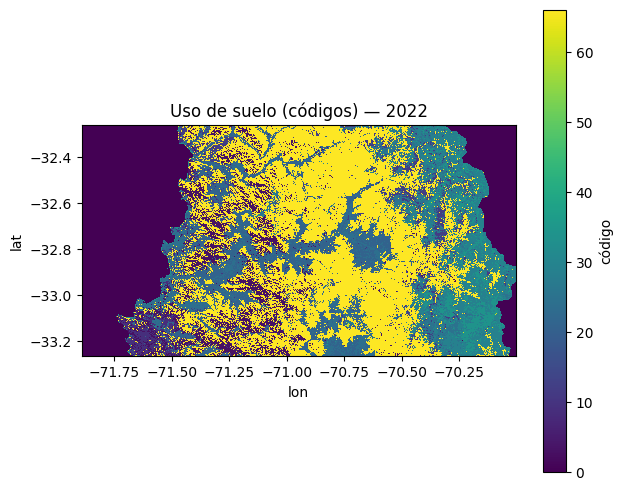

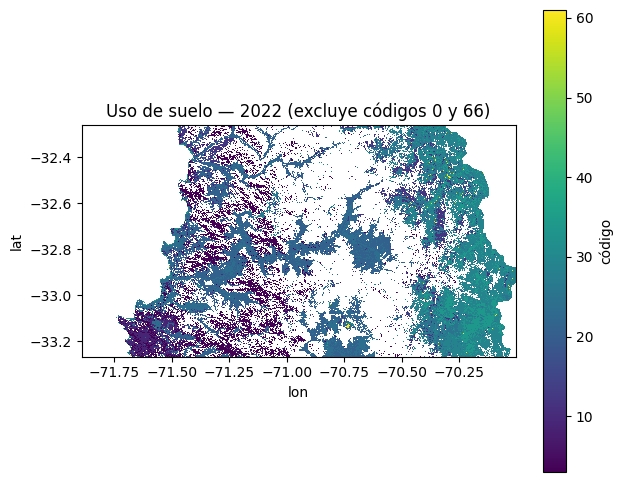

In [15]:
# Mapa rápido de la clase (2022 por defecto)
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

NC_PATH   = "/home/aninotna/magister/tesis/justh2_pipeline/data/mapbioma/nc/uso_suelo_stack.nc"
VAR_NAME  = "uso_suelo"
YEAR_MAP  = 2022  # cambia si quieres otro

# Abre el dataset (con o sin Dask)
try:
    import dask  # noqa
    ds = xr.open_dataset(NC_PATH, chunks={"lat": 1000, "lon": 1000})
except Exception:
    ds = xr.open_dataset(NC_PATH)

da = ds[VAR_NAME]
if "year" in da.dims:
    if YEAR_MAP not in da["year"].values:
        YEAR_MAP = int(da["year"].values[0])
    da = da.sel(year=YEAR_MAP)

# Downsample para visualización (si está muy grande)
step = 4  # aumenta si tu GPU/CPU sufre
da_small = da.isel(lat=slice(None, None, step), lon=slice(None, None, step))

# Extent para que el eje muestre lat/lon correctos
lat = da_small["lat"].values
lon = da_small["lon"].values
extent = [float(lon.min()), float(lon.max()), float(lat.min()), float(lat.max())]

plt.figure(figsize=(7, 6))
plt.imshow(da_small.values, origin="upper", extent=extent, interpolation="nearest")
plt.title(f"Uso de suelo (códigos) — {YEAR_MAP}")
plt.xlabel("lon"); plt.ylabel("lat")
plt.colorbar(label="código")
plt.show()

# Mapa "solo tierra" (oculta 0 y 66 provisionalmente)
arr = da_small.values.astype(float)
arr_masked = arr.copy()
arr_masked[np.isin(arr_masked, [0, 66])] = np.nan

plt.figure(figsize=(7, 6))
plt.imshow(arr_masked, origin="upper", extent=extent, interpolation="nearest")
plt.title(f"Uso de suelo — {YEAR_MAP} (excluye códigos 0 y 66)")
plt.xlabel("lon"); plt.ylabel("lat")
plt.colorbar(label="código")
plt.show()
